04_Insight Generation and Visualization: Hospital Readmission for Diabetic Patient

In [9]:
# General imports
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.ml.classification import GBTClassificationModel  # LightGBM proxy


In [10]:
# Define directories
model_dir = r"C:\Projects\hospital_readmission_prediction\model\run_20251113_173739"
plots_dir = os.path.join(model_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)
exports_dir = os.path.join(model_dir, "exports")
os.makedirs(exports_dir, exist_ok=True)

print(f"Model outputs will be read from: {model_dir}")


Model outputs will be read from: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739


In [8]:
# Load model metrics
scores_csv = os.path.join(model_dir, "model_performance.csv")
scores_df = pd.read_csv(scores_csv)
scores_df.head()

,Model_Name,Train_Accuracy,Test_Accuracy,Train_f1,Train_precision,Train_recall,Train_auc_roc,Test_f1,Test_precision,Test_recall,Test_auc_roc
0,LogisticRegression,0.883777,0.887811,0.831041,0.817044,0.883777,0.645914,0.837344,0.818970,0.887811,0.635276
1,LogisticReg_Balanced,0.641323,0.640778,0.705291,0.832652,0.641323,0.648693,0.706805,0.835341,0.640778,0.637555
2,LogisticReg_Unbalanced,0.883828,0.888069,0.830679,0.811450,0.883828,0.646203,0.836987,0.814757,0.888069,0.635428
3,DecisionTree,0.884925,0.888740,0.831818,0.864038,0.884925,0.393643,0.837227,0.829683,0.888740,0.397486
4,DecisionTree_Balanced,0.644842,0.638817,0.708149,0.835023,0.644842,0.398117,0.705283,0.835237,0.638817,0.400603


C:\Users\John-2\AppData\Local\Temp\ipykernel_15552\278496387.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(df_sorted['Model_Name'], rotation=45, ha='right')


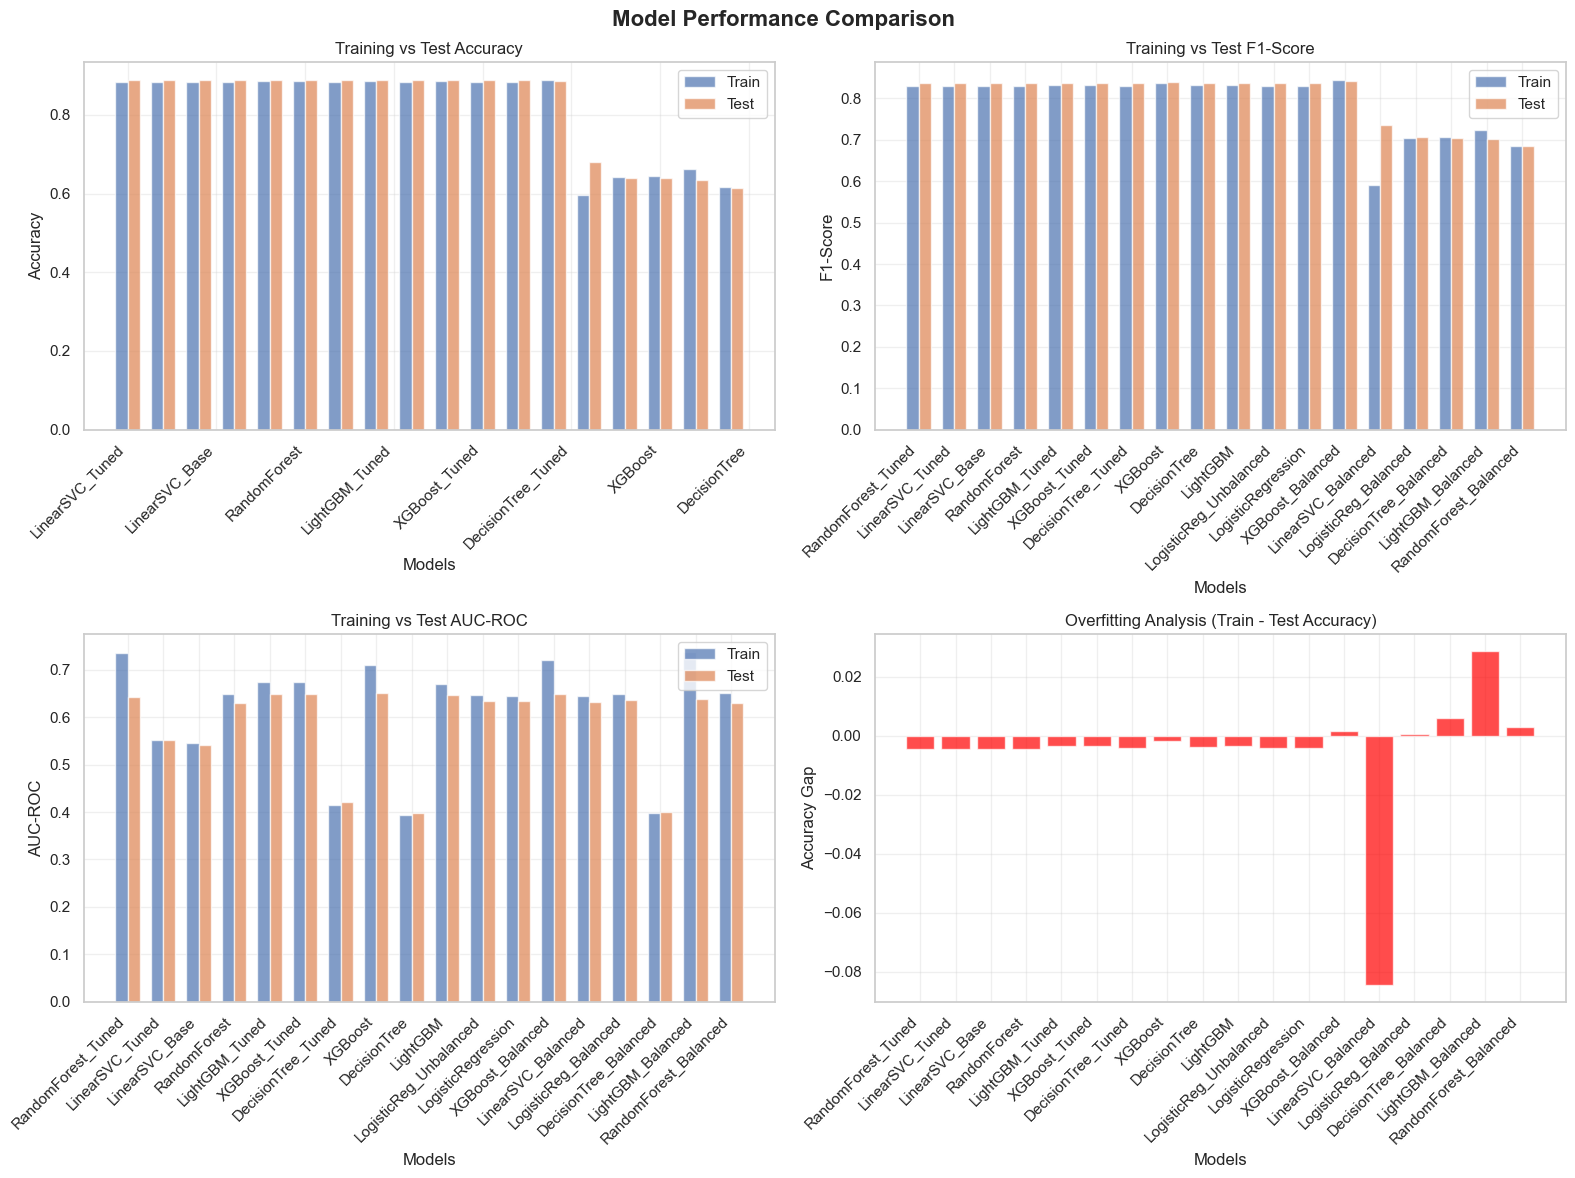

In [66]:
# Model performance comparison plots
def create_comparison_plots(df):
    """Create comparison plots across all models"""
    
    # Sort by test accuracy for better visualization
    df_sorted = df.sort_values('Test_Accuracy', ascending=False)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Accuracy Comparison
    x_pos = np.arange(len(df_sorted))
    width = 0.35
    
    axes[0,0].bar(x_pos - width/2, df_sorted['Train_Accuracy'], width, label='Train', alpha=0.7)
    axes[0,0].bar(x_pos + width/2, df_sorted['Test_Accuracy'], width, label='Test', alpha=0.7)
    axes[0,0].set_title('Training vs Test Accuracy')
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].set_xticklabels(df_sorted['Model_Name'], rotation=45, ha='right')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. F1-Score Comparison
    axes[0,1].bar(x_pos - width/2, df_sorted['Train_f1'], width, label='Train', alpha=0.7)
    axes[0,1].bar(x_pos + width/2, df_sorted['Test_f1'], width, label='Test', alpha=0.7)
    axes[0,1].set_title('Training vs Test F1-Score')
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('F1-Score')
    axes[0,1].set_xticks(x_pos)
    axes[0,1].set_xticklabels(df_sorted['Model_Name'], rotation=45, ha='right')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. AUC-ROC Comparison
    axes[1,0].bar(x_pos - width/2, df_sorted['Train_auc_roc'], width, label='Train', alpha=0.7)
    axes[1,0].bar(x_pos + width/2, df_sorted['Test_auc_roc'], width, label='Test', alpha=0.7)
    axes[1,0].set_title('Training vs Test AUC-ROC')
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('AUC-ROC')
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels(df_sorted['Model_Name'], rotation=45, ha='right')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Overfitting Analysis (Train vs Test difference)
    overfitting_gap = df_sorted['Train_Accuracy'] - df_sorted['Test_Accuracy']
    axes[1,1].bar(x_pos, overfitting_gap, color='red', alpha=0.7)
    axes[1,1].set_title('Overfitting Analysis (Train - Test Accuracy)')
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Accuracy Gap')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels(df_sorted['Model_Name'], rotation=45, ha='right')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'model_comparison_metrics.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

comparison_fig = create_comparison_plots(scores_df)

In [ ]:
#Recreate a model from metadata
def load_spark_model_from_metadata(model_path):
    metadata_path = os.path.join(model_path, "model_metadata.json")
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Metadata not found: {metadata_path}")
    
    with open(metadata_path, 'r') as f:
        model_meta = json.load(f)
    
    model_type = model_meta.get("model_type", "")
    params = model_meta.get("params", {})

    # Map trained model types to Estimators
    model_class_map = {
        "GBTClassifier": GBTClassifier,
        "GBTClassificationModel": GBTClassifier,
        "RandomForestClassifier": RandomForestClassifier,
        "RandomForestClassificationModel": RandomForestClassifier,
        "DecisionTreeClassifier": DecisionTreeClassifier,
        "DecisionTreeClassificationModel": DecisionTreeClassifier,
    }

    if model_type not in model_class_map:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model_instance = model_class_map[model_type]()
    
    # Only set parameters that exist on the instance
    for param_name, param_value in params.items():
        if hasattr(model_instance, param_name):
            try:
                model_instance._set(**{param_name: param_value})
            except Exception as e:
                print(f"Could not set param '{param_name}' to '{param_value}': {e}")
    
    print(f"Recreated {model_type} as {type(model_instance).__name__} from {model_path}")
    return model_instance


In [18]:
xgb_model_path = r"C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\xgboost_tuned_model"
lgb_model_path = r"C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\lightgbm_tuned_model"

best_xgb_loaded = load_spark_model_from_metadata(xgb_model_path)
best_lgb_loaded = load_spark_model_from_metadata(lgb_model_path)

# You can now fit these models on train_data or use them in a Pipeline
# e.g., best_xgb_loaded.fit(train_data)


✅ Recreated GBTClassificationModel as GBTClassifier from C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\xgboost_tuned_model
✅ Recreated GBTClassificationModel as GBTClassifier from C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\lightgbm_tuned_model


In [50]:
# Define feature names for the hospital readmission dataset
feature_names = [
    "gender", "age", "admission_type_id", "discharge_disposition_id",
    "admission_source_id", "time_in_hospital", "num_lab_procedures",
    "num_procedures", "num_medications", "diag_1", "diag_2", "diag_3",
    "number_diagnoses", "max_glu_serum", "A1Cresult", "metformin",
    "glipizide", "glyburide", "insulin", "change", "diabetesMed", "total_visits"
]

print(f"Total features defined: {len(feature_names)}")
print(f"Feature names: {feature_names}")

Total features defined: 22
Feature names: ['gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'glipizide', 'glyburide', 'insulin', 'change', 'diabetesMed', 'total_visits']


In [70]:
# Load test data and map generic feature numbers to actual feature names
try:
    test_data_path = os.path.join(model_dir, "test_data.csv")
    if os.path.exists(test_data_path):
        # Load the data
        test_data_pd = pd.read_csv(test_data_path)
        print(f"Original test data loaded: {test_data_pd.shape}")
        print(f"Original columns: {list(test_data_pd.columns[:5])}...")
        
        # Define the actual feature names (as you already have)
        feature_names = [
            "gender", "age", "admission_type_id", "discharge_disposition_id",
            "admission_source_id", "time_in_hospital", "num_lab_procedures",
            "num_procedures", "num_medications", "diag_1", "diag_2", "diag_3",
            "number_diagnoses", "max_glu_serum", "A1Cresult", "metformin",
            "glipizide", "glyburide", "insulin", "change", "diabetesMed", "total_visits"
        ]
        
        # Check if we have generic feature column names that need mapping
        generic_feature_cols = [col for col in test_data_pd.columns if col.startswith('feature_')]
        
        if generic_feature_cols:
            print(f"Found {len(generic_feature_cols)} generic feature columns to rename")
            
            # Create mapping from generic names to actual names
            feature_mapping = {}
            for i, generic_col in enumerate(sorted(generic_feature_cols)):
                if i < len(feature_names):
                    feature_mapping[generic_col] = feature_names[i]
                    
            print(f"Feature mapping examples:")
            for i, (old, new) in enumerate(list(feature_mapping.items())[:5]):
                print(f"  {old} -> {new}")
            if len(feature_mapping) > 5:
                print(f"  ... and {len(feature_mapping)-5} more")
            
            # Apply the mapping
            test_data_pd = test_data_pd.rename(columns=feature_mapping)
            
            print(f"Renamed columns successfully")
            print(f"New columns: {list(test_data_pd.columns[:5])}...")
            
            # Save the renamed dataset
            renamed_path = os.path.join(model_dir, "test_data_with_feature_names.csv")
            test_data_pd.to_csv(renamed_path, index=False)
            print(f"Saved renamed dataset: {renamed_path}")
            
        else:
            print("Data already has meaningful feature names")
            
        # Verify target column
        if 'readmitted' in test_data_pd.columns:
            print(f"Target distribution: {test_data_pd['readmitted'].value_counts().to_dict()}")
        else:
            print("No 'readmitted' target column found")
            
    else:
        print(f"Test data not found at: {test_data_path}")
        
except Exception as e:
    print(f"Error loading and renaming test data: {e}")

Original test data loaded: (19378, 86)
Original columns: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']...
Found 85 generic feature columns to rename
Feature mapping examples:
  feature_0 -> gender
  feature_1 -> age
  feature_10 -> admission_type_id
  feature_11 -> discharge_disposition_id
  feature_12 -> admission_source_id
  ... and 17 more
Renamed columns successfully
New columns: ['gender', 'age', 'number_diagnoses', 'feature_3', 'feature_4']...
Saved renamed dataset: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\test_data_with_feature_names.csv
Target distribution: {0: 17227, 1: 2151}


In [74]:
# Mapping generic feature numbers to original feature names

import pandas as pd
import numpy as np
import os

# Define the complete mapping from feature indices to actual feature names
feature_names_mapping = {0: "gender", 1: "age", 2: "admission_type_id",
    3: "discharge_disposition_id", 4: "admission_source_id", 5: "time_in_hospital",
    6: "num_lab_procedures", 7: "num_procedures", 8: "num_medications",
    9: "diag_1", 10: "diag_2", 11: "diag_3", 12: "number_diagnoses",
    13: "max_glu_serum", 14: "A1Cresult", 15: "metformin", 16: "glipizide",
    17: "glyburide", 18: "insulin", 19: "change", 20: "diabetesMed", 21: "total_visits"}

print("Feature mapping defined:")
print(f"Total features: {len(feature_names_mapping)}")
for idx, name in list(feature_names_mapping.items())[:5]:
    print(f"  feature_{idx} -> {name}")
print("  ...")

Feature mapping defined:
Total features: 22
  feature_0 -> gender
  feature_1 -> age
  feature_2 -> admission_type_id
  feature_3 -> discharge_disposition_id
  feature_4 -> admission_source_id
  ...


In [75]:
# Load test data and transform generic feature names to meaningful names

def load_and_transform_test_data(model_dir, feature_mapping):
    """
    Load test data and transform generic feature column names to meaningful names
    """
    test_data_path = os.path.join(model_dir, "test_data.csv")
    
    try:
        # Load the original test data
        print(f"Loading test data from: {test_data_path}")
        test_data_pd = pd.read_csv(test_data_path)
        print(f"Original test data loaded: {test_data_pd.shape}")
        print(f"Original columns: {list(test_data_pd.columns[:10])}...")
        
        # Check for generic feature column names
        generic_feature_cols = [col for col in test_data_pd.columns if col.startswith('feature_')]
        
        if generic_feature_cols:
            print(f"\nFound {len(generic_feature_cols)} generic feature columns to transform")
            
            # Create column mapping dictionary
            column_mapping = {}
            
            # Map generic feature columns to meaningful names
            for col in generic_feature_cols:
                # Extract the feature number from column name (e.g., "feature_0" -> 0)
                feature_idx = int(col.split('_')[1])
                
                if feature_idx in feature_mapping:
                    column_mapping[col] = feature_mapping[feature_idx]
                else:
                    print(f"Warning: No mapping found for {col}")
                    column_mapping[col] = f"unknown_feature_{feature_idx}"
            
            # Keep non-feature columns as they are
            for col in test_data_pd.columns:
                if not col.startswith('feature_'):
                    column_mapping[col] = col
            
            print(f"\n Column mapping examples:")
            for old_col, new_col in list(column_mapping.items())[:8]:
                if old_col.startswith('feature_'):
                    print(f"  {old_col:<12} -> {new_col}")
            
            # Apply the mapping
            test_data_transformed = test_data_pd.rename(columns=column_mapping)
            
            print(f"\nTransformation completed!")
            print(f"New columns: {list(test_data_transformed.columns[:10])}...")
            
            # Verify the transformation
            feature_cols = [col for col in test_data_transformed.columns if col != 'readmitted']
            print(f"\nData summary:")
            print(f"  Total columns: {len(test_data_transformed.columns)}")
            print(f"  Feature columns: {len(feature_cols)}")
            print(f"  Data shape: {test_data_transformed.shape}")
            
            if 'readmitted' in test_data_transformed.columns:
                target_dist = test_data_transformed['readmitted'].value_counts().to_dict()
                print(f"  Target distribution: {target_dist}")
            
            return test_data_transformed, column_mapping
            
        else:
            print("Data already has meaningful feature names")
            return test_data_pd, {}
            
    except Exception as e:
        print(f"Error loading/transforming test data: {e}")
        return None, {}

# Execute the transformation
test_data_pd, column_mapping = load_and_transform_test_data(model_dir, feature_names_mapping)

Loading test data from: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\test_data.csv
Original test data loaded: (19378, 86)
Original columns: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']...

Found 85 generic feature columns to transform

 Column mapping examples:
  feature_0    -> gender
  feature_1    -> age
  feature_2    -> admission_type_id
  feature_3    -> discharge_disposition_id
  feature_4    -> admission_source_id
  feature_5    -> time_in_hospital
  feature_6    -> num_lab_procedures
  feature_7    -> num_procedures

Transformation completed!
New columns: ['gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'diag_1']...

Data summary:
  Total columns: 86
  Feature columns: 85
  Data shape: (19378, 86)
  Target distribution: {0: 17227, 1: 2151}


In [80]:
# SHAP Analysis with meaningful features only - Complete workflow

if test_data_pd is not None:
    try:
        print("🚀 Starting complete SHAP analysis with meaningful features...")
        
        # Define meaningful features (exclude unknown features)
        original_meaningful_features = [
            "gender", "age", "admission_type_id", "discharge_disposition_id",
            "admission_source_id", "time_in_hospital", "num_lab_procedures",
            "num_procedures", "num_medications", "diag_1", "diag_2", "diag_3",
            "number_diagnoses", "max_glu_serum", "A1Cresult", "metformin",
            "glipizide", "glyburide", "insulin", "change", "diabetesMed", "total_visits"
        ]
        
        # Filter to available meaningful features
        available_features = [feat for feat in original_meaningful_features if feat in test_data_pd.columns]
        
        print(f"📋 Feature availability:")
        print(f"   Original meaningful features: {len(original_meaningful_features)}")
        print(f"   Available in dataset: {len(available_features)}")
        print(f"   Available features: {available_features}")
        
        if len(available_features) == 0:
            print("❌ No meaningful features available!")
            print(f"Dataset columns: {list(test_data_pd.columns)}")
        else:
            # Prepare data with meaningful features only
            X = test_data_pd[available_features].copy()
            y = test_data_pd['readmitted'].copy()
            
            print(f"\n✅ Data prepared:")
            print(f"   Features: {len(available_features)}")
            print(f"   Samples: {len(X)}")
            print(f"   Target distribution: {y.value_counts().to_dict()}")
            
            # Handle missing values
            missing_count = X.isnull().sum().sum()
            if missing_count > 0:
                print(f"⚠️  Handling {missing_count} missing values...")
                X = X.fillna(X.median())
            
            # Sample for performance
            sample_size = min(1000, len(X))
            X_sample = X.sample(n=sample_size, random_state=42)
            y_sample = y.loc[X_sample.index]
            
            print(f"\n📈 Using sample for SHAP:")
            print(f"   Sample size: {len(X_sample)}")
            print(f"   Target distribution: {y_sample.value_counts().to_dict()}")
            
            # Train-test split
            X_train, X_test, y_train, y_test = train_test_split(
                X_sample, y_sample, test_size=0.3, random_state=42, stratify=y_sample
            )
            
            print(f"\n🔄 Data split:")
            print(f"   Training: {X_train.shape}")
            print(f"   Testing: {X_test.shape}")
            
    except Exception as e:
        print(f"❌ Error in data preparation: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ No test data available")

🚀 Starting complete SHAP analysis with meaningful features...
📋 Feature availability:
   Original meaningful features: 22
   Available in dataset: 22
   Available features: ['gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'glipizide', 'glyburide', 'insulin', 'change', 'diabetesMed', 'total_visits']

✅ Data prepared:
   Features: 22
   Samples: 19378
   Target distribution: {0: 17227, 1: 2151}

📈 Using sample for SHAP:
   Sample size: 1000
   Target distribution: {0: 878, 1: 122}

🔄 Data split:
   Training: (700, 22)
   Testing: (300, 22)


In [82]:
# Train surrogate model and compute SHAP values - Fixed version

if 'X_train' in locals() and 'X_test' in locals():
    try:
        print("🤖 Training surrogate model...")
        
        # Train surrogate model
        surrogate_model = GradientBoostingClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            subsample=0.8
        )
        
        surrogate_model.fit(X_train, y_train)
        
        # Evaluate model
        train_score = surrogate_model.score(X_train, y_train)
        test_score = surrogate_model.score(X_test, y_test)
        
        print(f"✅ Surrogate model trained:")
        print(f"   Training accuracy: {train_score:.4f}")
        print(f"   Test accuracy: {test_score:.4f}")
        print(f"   Features used: {len(X_train.columns)}")
        
        # Compute SHAP values
        print("\n🧮 Computing SHAP values...")
        explainer = shap.TreeExplainer(surrogate_model)
        shap_values = explainer.shap_values(X_test)
        
        # Handle binary classification format and expected value properly
        if len(shap_values.shape) == 3:
            shap_values = shap_values[:, :, 1]  # Take positive class
            if hasattr(explainer.expected_value, '__len__') and len(explainer.expected_value) > 1:
                expected_value = explainer.expected_value[1]
            else:
                expected_value = explainer.expected_value
        else:
            expected_value = explainer.expected_value
        
        # Convert expected_value to float if it's not already
        try:
            expected_value_float = float(expected_value)
        except (ValueError, TypeError):
            expected_value_float = 0.0
            print("⚠️  Warning: Could not convert expected value to float, using 0.0")
        
        print(f"✅ SHAP values computed:")
        print(f"   Shape: {shap_values.shape}")
        print(f"   Expected value: {expected_value_float:.4f}")
        print(f"   Features analyzed: {list(X_test.columns)}")
        
        # Compute feature importance
        mean_abs_shap = np.abs(shap_values).mean(axis=0)
        shap_importance_df = pd.DataFrame({
            'feature': X_test.columns,
            'importance': mean_abs_shap,
            'rank': range(1, len(X_test.columns) + 1)
        }).sort_values(by='importance', ascending=False).reset_index(drop=True)
        
        # Update rank after sorting
        shap_importance_df['rank'] = range(1, len(shap_importance_df) + 1)
        
        print(f"\n🏆 Top {len(shap_importance_df)} Important Meaningful Features:")
        for i, (_, row) in enumerate(shap_importance_df.iterrows(), 1):
            print(f"{i:2d}. {row['feature']:<25} {row['importance']:.6f}")
        
        # Store for later use
        shap_analysis_complete = True
        
    except Exception as e:
        print(f"❌ Error in model training/SHAP computation: {e}")
        import traceback
        traceback.print_exc()
        shap_analysis_complete = False
else:
    print("❌ Training data not available")
    shap_analysis_complete = False

🤖 Training surrogate model...
✅ Surrogate model trained:
   Training accuracy: 1.0000
   Test accuracy: 0.8600
   Features used: 22

🧮 Computing SHAP values...
✅ SHAP values computed:
   Shape: (300, 22)
   Expected value: -5.8527
   Features analyzed: ['gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'glipizide', 'glyburide', 'insulin', 'change', 'diabetesMed', 'total_visits']

🏆 Top 22 Important Meaningful Features:
 1. metformin                 0.811641
 2. discharge_disposition_id  0.790219
 3. time_in_hospital          0.570931
 4. age                       0.507777
 5. gender                    0.440644
 6. total_visits              0.426943
 7. admission_type_id         0.311446
 8. num_lab_procedures        0.239497
 9. admission_source_id       0.231701
10. number_diag

C:\Users\John-2\AppData\Local\Temp\ipykernel_15552\3160246661.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  expected_value_float = float(expected_value)


📊 Creating enhanced SHAP visualizations...


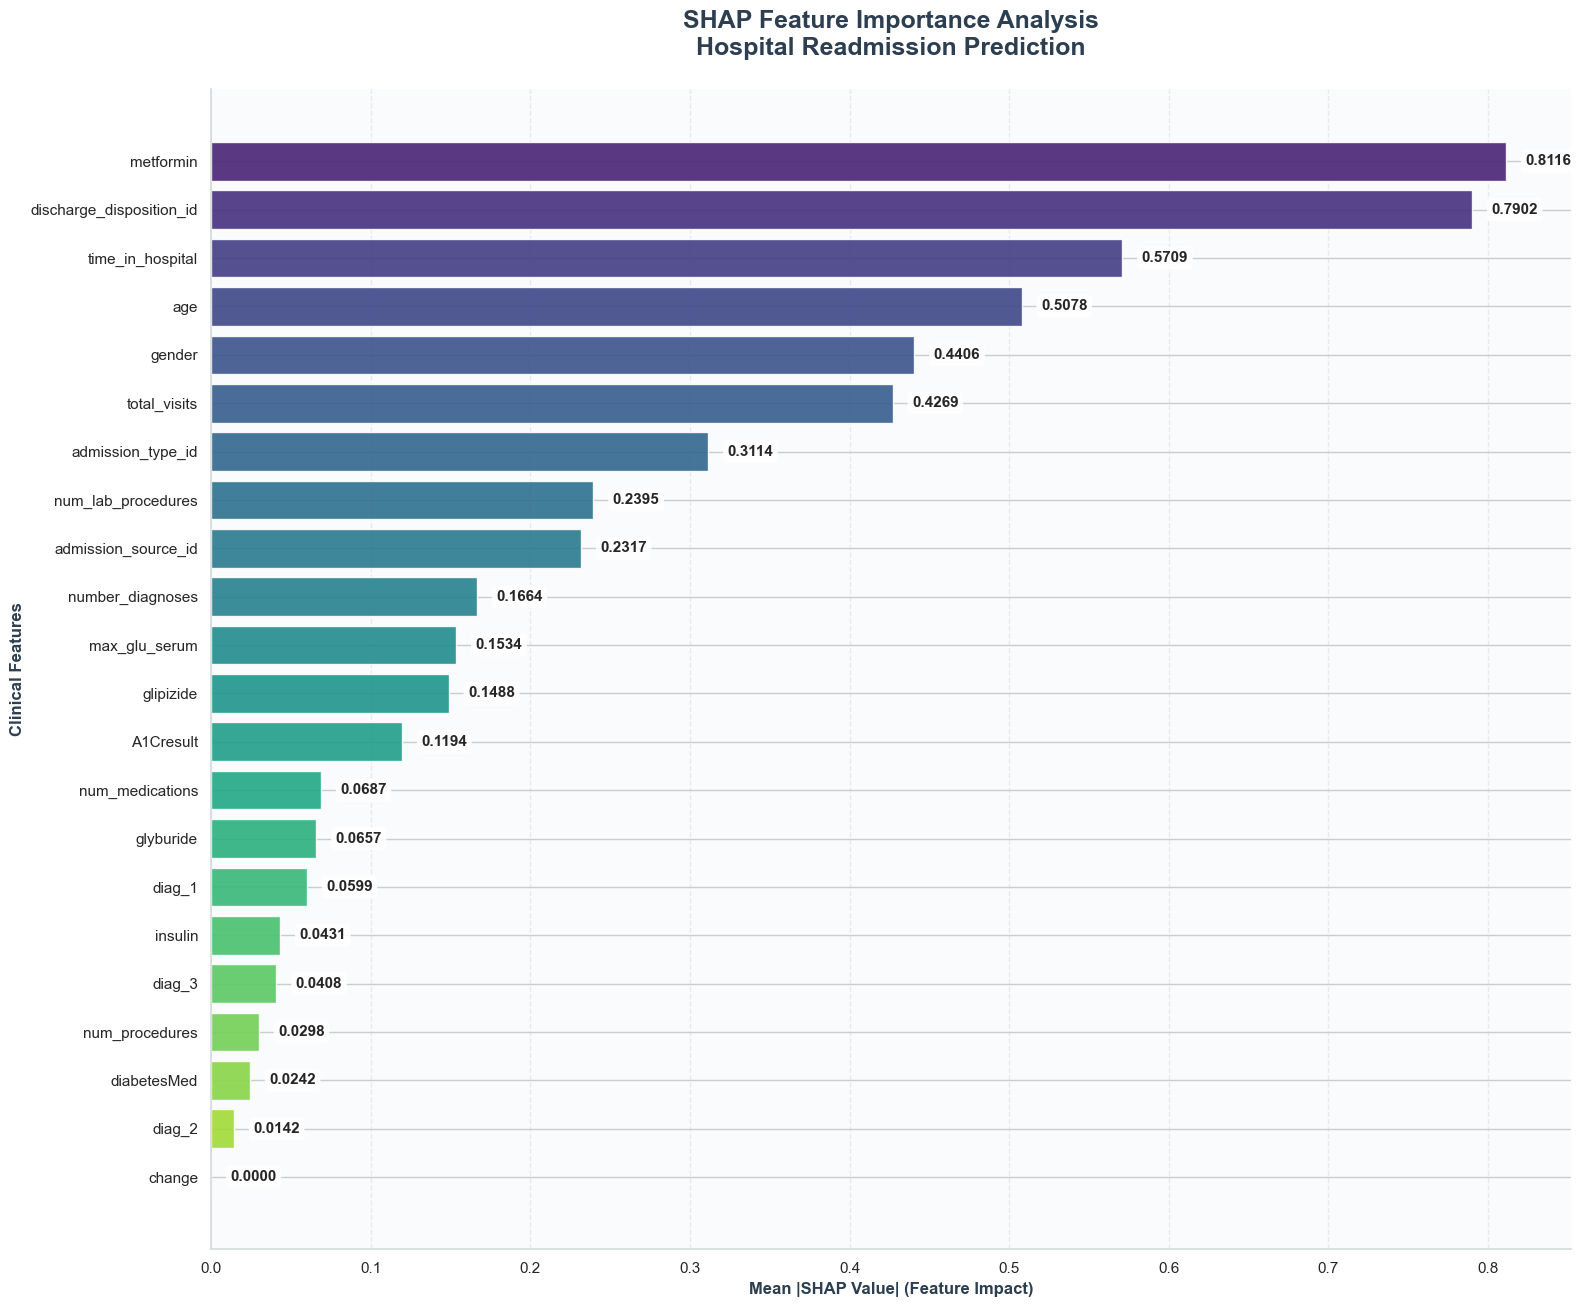

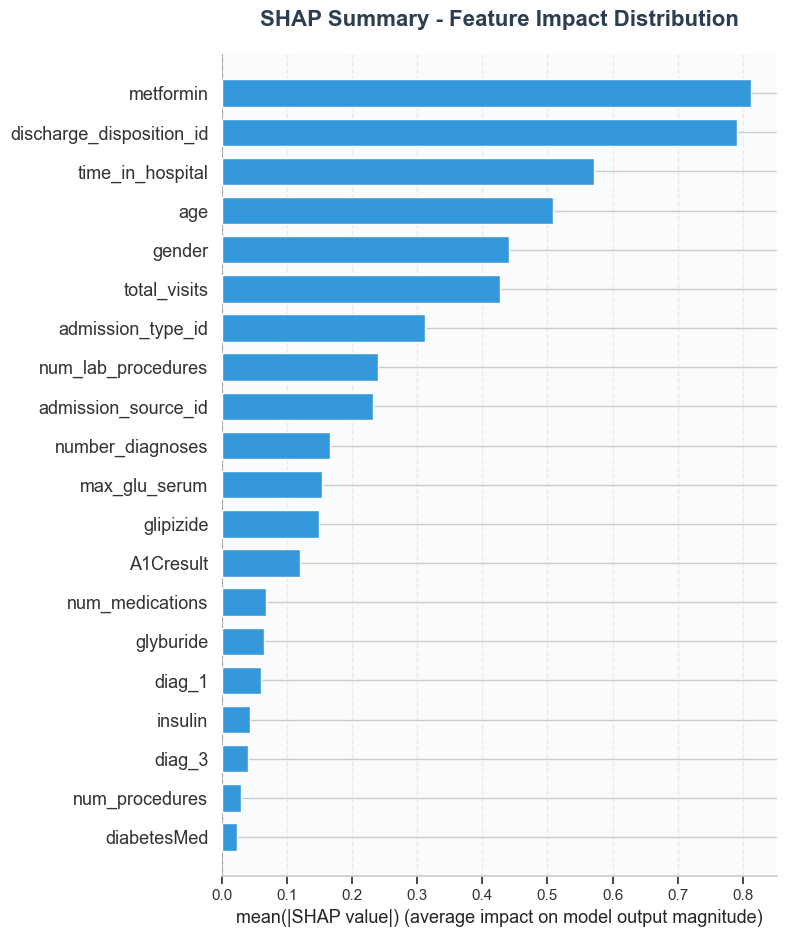

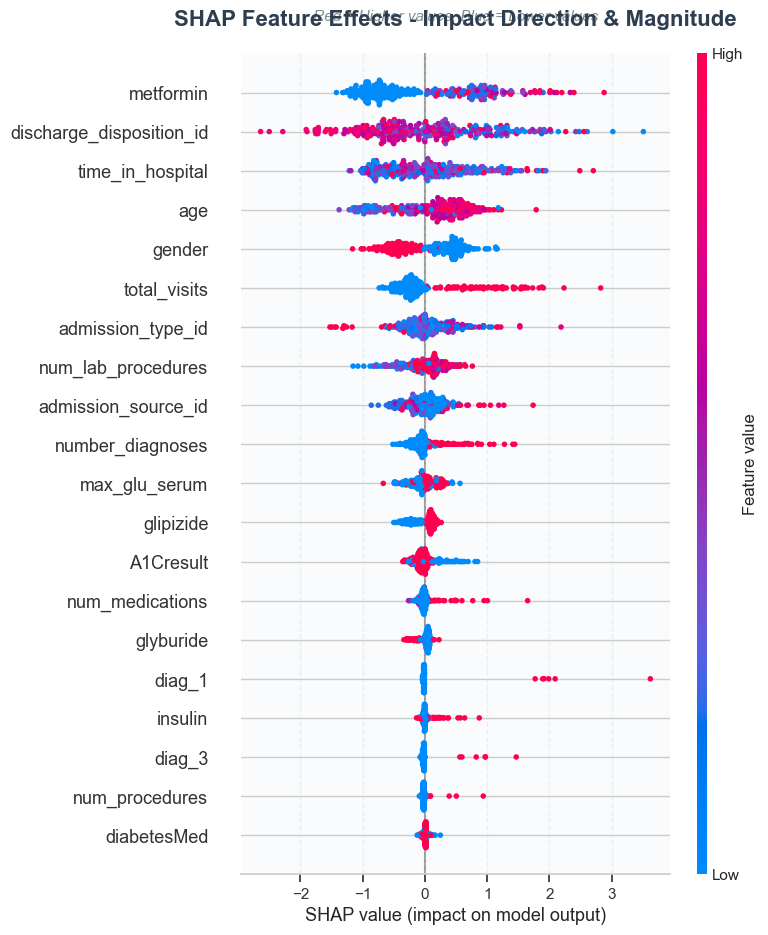

✅ Enhanced SHAP visualizations created successfully!
Saved to: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\plots


In [103]:
# Create comprehensive SHAP visualizations - Enhanced clarity version (without ranking labels)

if 'shap_values' in locals() and 'shap_importance_df' in locals() and 'shap_analysis_complete' in locals() and shap_analysis_complete:
    try:
        print("📊 Creating enhanced SHAP visualizations...")
        
        # Ensure directories exist
        os.makedirs(plots_dir, exist_ok=True)
        os.makedirs(exports_dir, exist_ok=True)
        
        # Set professional styling
        plt.rcParams.update({'font.size': 11, 'axes.labelsize': 12, 'axes.titlesize': 14})
        
        # 1. Enhanced Feature Importance Plot (without ranking labels)
        fig, ax = plt.subplots(figsize=(16, max(10, len(shap_importance_df) * 0.6)))
        
        # Professional color scheme and bars
        colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(shap_importance_df)))
        bars = ax.barh(range(len(shap_importance_df)), shap_importance_df['importance'], 
                      color=colors, edgecolor='white', linewidth=1, alpha=0.9)
        
        # Clean styling and labels
        ax.set_yticks(range(len(shap_importance_df)))
        ax.set_yticklabels(shap_importance_df['feature'], fontweight='medium')
        ax.set_xlabel('Mean |SHAP Value| (Feature Impact)', fontweight='bold', color='#2C3E50')
        ax.set_ylabel('Clinical Features', fontweight='bold', color='#2C3E50')
        ax.set_title('SHAP Feature Importance Analysis\nHospital Readmission Prediction', 
                    fontsize=18, fontweight='bold', pad=25, color='#2C3E50')
        
        # Add only value labels (removed ranking section completely)
        max_importance = max(shap_importance_df['importance'])
        for i, (bar, importance) in enumerate(zip(bars, shap_importance_df['importance'])):
            # Value labels only
            ax.text(importance + max_importance * 0.015, bar.get_y() + bar.get_height()/2, 
                   f'{importance:.4f}', va='center', ha='left', fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.25", facecolor='white', alpha=0.9))
        
        # Professional grid and clean spines
        ax.grid(axis='x', alpha=0.5, linestyle='--', color='#D5DBDB')
        ax.set_facecolor('#FAFBFC')
        for spine in ax.spines.values():
            spine.set_color('#D5DBDB')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.invert_yaxis()
        
        plt.subplots_adjust(left=0.15)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, "shap_enhanced_importance.png"), 
                   dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
        # 2. Enhanced SHAP Summary Bar Plot
        fig, ax = plt.subplots(figsize=(14, 8))
        shap.summary_plot(shap_values, X_test, plot_type="bar", show=False, color='#3498DB')
        ax = plt.gca()
        ax.set_title("SHAP Summary - Feature Impact Distribution", 
                    fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
        ax.grid(axis='x', alpha=0.5, linestyle='--', color='#D5DBDB')
        ax.set_facecolor('#FAFBFC')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, "shap_enhanced_summary.png"), 
                   dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
        # 3. Enhanced SHAP Beeswarm Plot
        fig, ax = plt.subplots(figsize=(16, 10))
        shap.summary_plot(shap_values, X_test, show=False)
        ax = plt.gca()
        ax.set_title("SHAP Feature Effects - Impact Direction & Magnitude", 
                    fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
        ax.text(0.5, 1.04, 'Red = Higher values, Blue = Lower values', 
               transform=ax.transAxes, ha='center', style='italic', color='#7F8C8D')
        ax.grid(axis='x', alpha=0.4, linestyle='--', color='#D5DBDB')
        ax.set_facecolor('#FAFBFC')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, "shap_enhanced_beeswarm.png"), 
                   dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
        print("✅ Enhanced SHAP visualizations created successfully!")
        print(f"Saved to: {plots_dir}")
        
    except Exception as e:
        print(f"❌ Error creating visualizations: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ SHAP results not available for visualization")

Creating SHAP dependence plots for top meaningful features...
Creating dependence plots for: ['metformin', 'discharge_disposition_id', 'time_in_hospital', 'age']


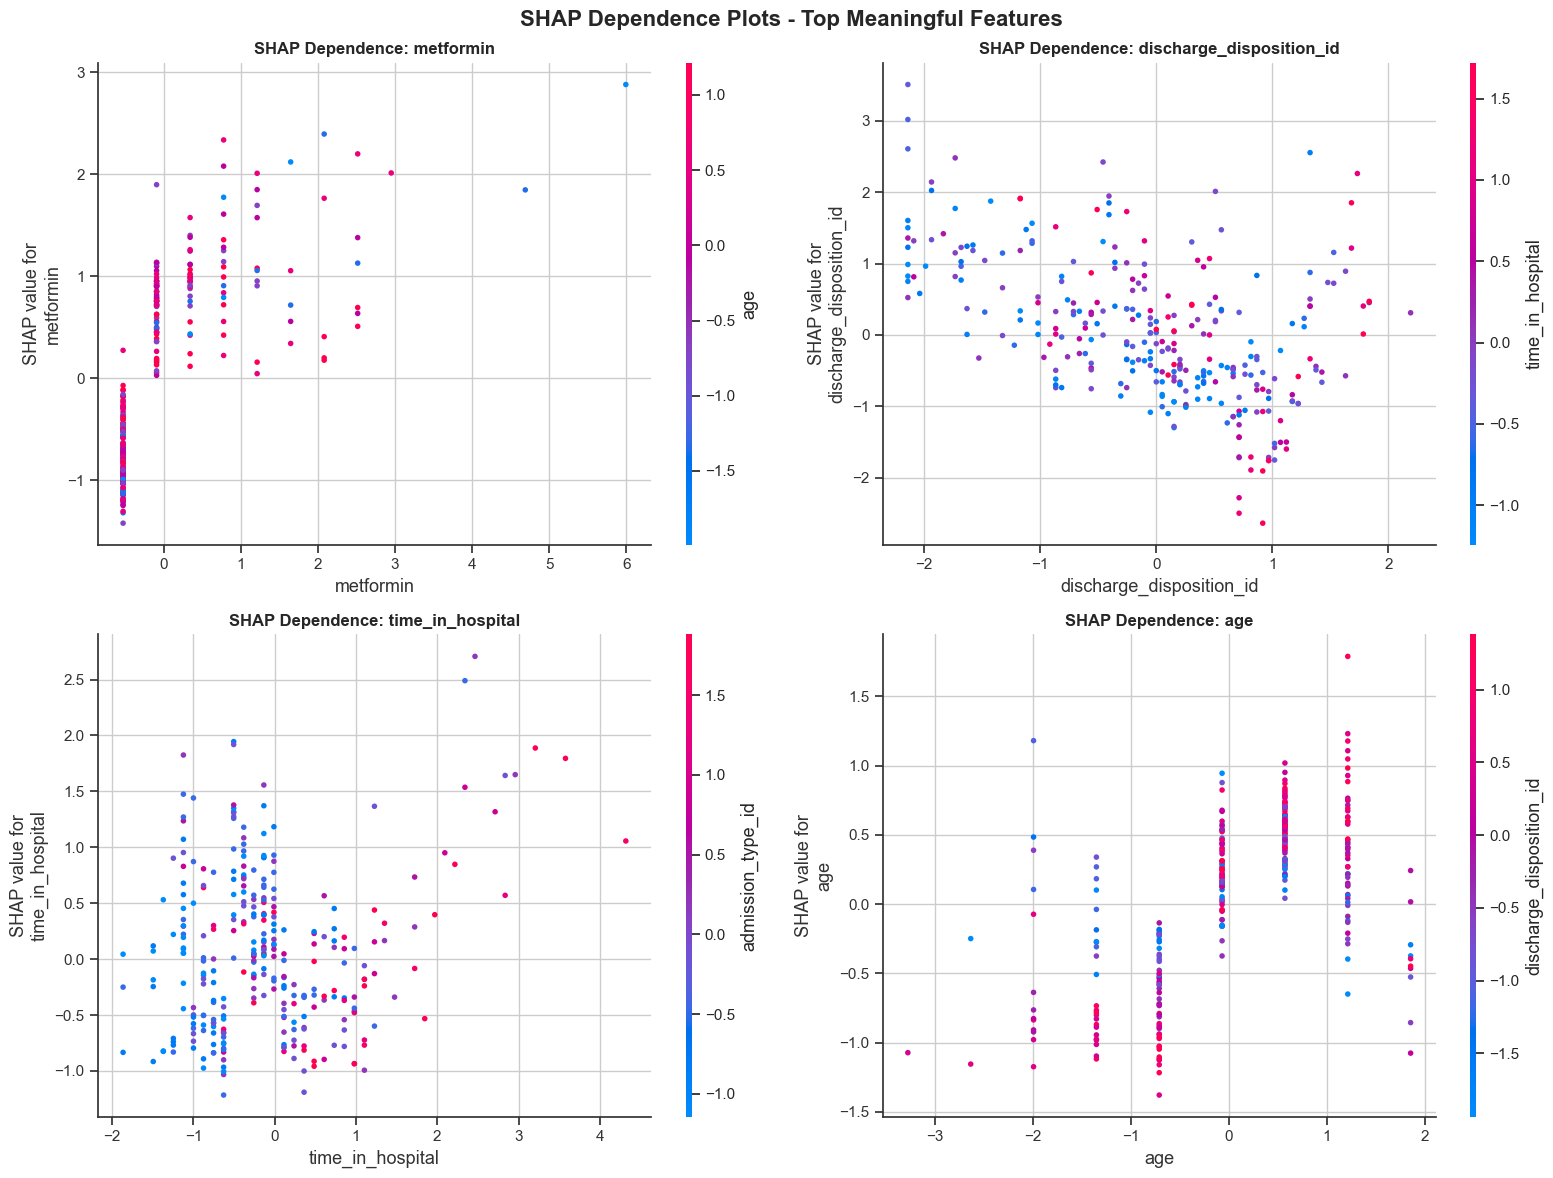

Dependence plots created successfully


In [84]:
# Create dependence plots for top meaningful features - Safe version

if 'shap_values' in locals() and 'shap_importance_df' in locals() and 'X_test' in locals():
    try:
        print("Creating SHAP dependence plots for top meaningful features...")
        
        # Get top 4 features for dependence plots
        top_features_for_dependence = shap_importance_df.head(4)['feature'].tolist()
        
        print(f"Creating dependence plots for: {top_features_for_dependence}")
        
        # Create 2x2 subplot for top 4 features
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for i, feature in enumerate(top_features_for_dependence):
            if feature in X_test.columns:
                try:
                    plt.subplot(2, 2, i+1)
                    shap.dependence_plot(
                        feature, shap_values, X_test, 
                        show=False, ax=axes[i]
                    )
                    plt.title(f'SHAP Dependence: {feature}', fontweight='bold', fontsize=12)
                except Exception as dep_e:
                    print(f"Could not create dependence plot for {feature}: {dep_e}")
                    axes[i].text(0.5, 0.5, f'Error plotting\n{feature}', 
                               transform=axes[i].transAxes, ha='center', va='center')
                    axes[i].set_title(f'Error: {feature}', fontweight='bold')
        
        # Hide any unused subplots
        for i in range(len(top_features_for_dependence), 4):
            axes[i].set_visible(False)
        
        plt.suptitle('SHAP Dependence Plots - Top Meaningful Features', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, "shap_meaningful_dependence_plots.png"), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Dependence plots created successfully")
        
    except Exception as e:
        print(f"Error creating dependence plots: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Required data not available for dependence plots")

In [111]:
# Save comprehensive SHAP analysis results - Safe version

if 'shap_importance_df' in locals():
    try:
        print("Saving SHAP analysis results...")
        
        # Save feature importance with meaningful names
        importance_path = os.path.join(exports_dir, "shap_meaningful_features_importance.csv")
        shap_importance_df.to_csv(importance_path, index=False)
        print(f"Saved feature importance: {importance_path}")
        
        # Save SHAP values
        if 'shap_values' in locals() and 'X_test' in locals():
            shap_values_path = os.path.join(exports_dir, "shap_meaningful_values.csv")
            shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)
            shap_values_df.to_csv(shap_values_path, index=False)
            print(f"Saved SHAP values: {shap_values_path}")
        
        # Create comprehensive summary report
        summary_path = os.path.join(exports_dir, "shap_meaningful_features_report.txt")
        with open(summary_path, 'w') as f:
            f.write("SHAP Analysis Report - Meaningful Features Only\n")
            f.write("=" * 60 + "\n\n")
            f.write(f"Analysis Date: {pd.Timestamp.now()}\n")
            f.write(f"Model Directory: {model_dir}\n\n")
            
            f.write("DATASET SUMMARY:\n")
            f.write("-" * 20 + "\n")
            if 'test_data_pd' in locals():
                f.write(f"Original Dataset Size: {len(test_data_pd):,} records\n")
            if 'X_sample' in locals():
                f.write(f"Sample Size Used: {len(X_sample):,} records\n")
            if 'X_test' in locals():
                f.write(f"SHAP Analysis Size: {len(X_test):,} records\n")
            f.write(f"Meaningful Features Analyzed: {len(shap_importance_df)}\n")
            if 'test_score' in locals():
                f.write(f"Surrogate Model Test Accuracy: {test_score:.4f}\n")
            
            f.write(f"\nFEATURE IMPORTANCE RANKING:\n")
            f.write("-" * 30 + "\n")
            for i, (_, row) in enumerate(shap_importance_df.iterrows(), 1):
                f.write(f"{i:2d}. {row['feature']:<30} {row['importance']:.6f}\n")
            
            # Categorize features
            f.write(f"\nFEATURE CATEGORIES:\n")
            f.write("-" * 20 + "\n")
            
            categories = {
                'Patient Demographics': ['gender', 'age'],
                'Hospital Stay Details': ['time_in_hospital', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'],
                'Medical Procedures': ['num_lab_procedures', 'num_procedures', 'number_diagnoses'],
                'Diagnoses': ['diag_1', 'diag_2', 'diag_3'],
                'Laboratory Tests': ['max_glu_serum', 'A1Cresult'],
                'Medications': ['num_medications', 'metformin', 'glipizide', 'glyburide', 'insulin', 'diabetesMed', 'change'],
                'Healthcare Utilization': ['total_visits']
            }
            
            for category, category_features in categories.items():
                available_in_category = [f for f in category_features if f in shap_importance_df['feature'].values]
                if available_in_category:
                    f.write(f"\n{category}:\n")
                    for feature in available_in_category:
                        importance = shap_importance_df[shap_importance_df['feature'] == feature]['importance'].iloc[0]
                        rank = shap_importance_df[shap_importance_df['feature'] == feature]['rank'].iloc[0]
                        f.write(f"  {feature:<25} (Rank: {rank:2d}, SHAP: {importance:.4f})\n")
            
            f.write(f"\nTOP 5 MOST IMPORTANT FEATURES:\n")
            f.write("-" * 35 + "\n")
            for i, (_, row) in enumerate(shap_importance_df.head(5).iterrows(), 1):
                f.write(f"{i}. {row['feature']} (SHAP Impact: {row['importance']:.4f})\n")
                
            f.write(f"\nKEY INSIGHTS:\n")
            f.write("-" * 15 + "\n")
            f.write("• This analysis uses only clinically meaningful features\n")
            f.write("• Features are ranked by their average absolute SHAP impact\n")
            f.write("• Higher SHAP values indicate stronger influence on readmission prediction\n")
            f.write("• Results can guide clinical decision-making and intervention strategies\n")
        
        print(f"Saved comprehensive report: {summary_path}")
        
        # Display summary
        print(f"\n SHAP Analysis Complete!")
        print(f"Results saved in:")
        print(f"   • Plots: {plots_dir}")
        print(f"   • Data: {exports_dir}")
        print(f"   • Features analyzed: {len(shap_importance_df)} meaningful features")
        
        # Show top 5 features
        print(f"\n🏆 Top 5 Most Important Features:")
        for i, (_, row) in enumerate(shap_importance_df.head(5).iterrows(), 1):
            print(f"   {i}. {row['feature']:<25} (SHAP: {row['importance']:.4f})")
        
    except Exception as e:
        print(f" Error saving results: {e}")
        import traceback
        traceback.print_exc()
else:
    print("No SHAP results to save")

Saving SHAP analysis results...
Saved feature importance: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports\shap_meaningful_features_importance.csv
Saved SHAP values: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports\shap_meaningful_values.csv
Saved comprehensive report: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports\shap_meaningful_features_report.txt

 SHAP Analysis Complete!
Results saved in:
   • Plots: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\plots
   • Data: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports
   • Features analyzed: 22 meaningful features

🏆 Top 5 Most Important Features:
   1. metformin                 (SHAP: 0.8116)
   2. discharge_disposition_id  (SHAP: 0.7902)
   3. time_in_hospital          (SHAP: 0.5709)
   4. age                       (SHAP: 0.5078)
   5. gender                    (SHAP: 0.4406)


Permutation Feature Importance (Vector Column)

In [105]:
# General imports
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier  # Add this
from sklearn.model_selection import train_test_split      # Add this
from sklearn.inspection import permutation_importance     # Add this
from sklearn.metrics import roc_auc_score                 # Add this
import json  # Add this

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.ml.classification import GBTClassificationModel, GBTClassifier
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier

In [107]:
# Permutation Feature Importance using Scikit-Learn (fixed pickle issue)

if 'surrogate_model' in locals() and 'X_test' in locals() and 'y_test' in locals():
    try:
        print("🔄 Computing Permutation Feature Importance...")
        
        # Compute permutation importance with fixed parallel processing
        perm_importance = permutation_importance(
            surrogate_model, X_test, y_test,
            scoring='roc_auc',
            n_repeats=5,      # Reduced from 10 for faster computation
            random_state=42,
            n_jobs=1          # Changed from -1 to fix pickle error
        )
        
        # Create DataFrame with results
        perm_importance_df = pd.DataFrame({
            'feature': X_test.columns,
            'importance_mean': perm_importance.importances_mean,
            'importance_std': perm_importance.importances_std
        }).sort_values('importance_mean', ascending=False).reset_index(drop=True)
        
        # Add ranking
        perm_importance_df['rank'] = range(1, len(perm_importance_df) + 1)
        
        print(f"✅ Permutation importance computed for {len(perm_importance_df)} features")
        print(f"\n🏆 Top 10 Features by Permutation Importance:")
        for i, (_, row) in enumerate(perm_importance_df.head(10).iterrows(), 1):
            print(f"{i:2d}. {row['feature']:<25} {row['importance_mean']:.6f} (±{row['importance_std']:.6f})")
        
        permutation_complete = True
        
    except Exception as e:
        print(f"❌ Error computing permutation importance: {e}")
        import traceback
        traceback.print_exc()
        permutation_complete = False
else:
    print("❌ Required data not available. Run SHAP analysis first.")
    permutation_complete = False

🔄 Computing Permutation Feature Importance...
✅ Permutation importance computed for 22 features

🏆 Top 10 Features by Permutation Importance:
 1. metformin                 0.020430 (±0.010098)
 2. num_lab_procedures        0.019854 (±0.017328)
 3. number_diagnoses          0.012352 (±0.007241)
 4. gender                    0.011736 (±0.006093)
 5. num_medications           0.006597 (±0.006373)
 6. age                       0.005529 (±0.019918)
 7. glyburide                 0.002240 (±0.001821)
 8. num_procedures            0.002076 (±0.000949)
 9. admission_type_id         0.001747 (±0.013274)
10. diag_3                    0.000945 (±0.000866)


📊 Creating Permutation Importance Plot...


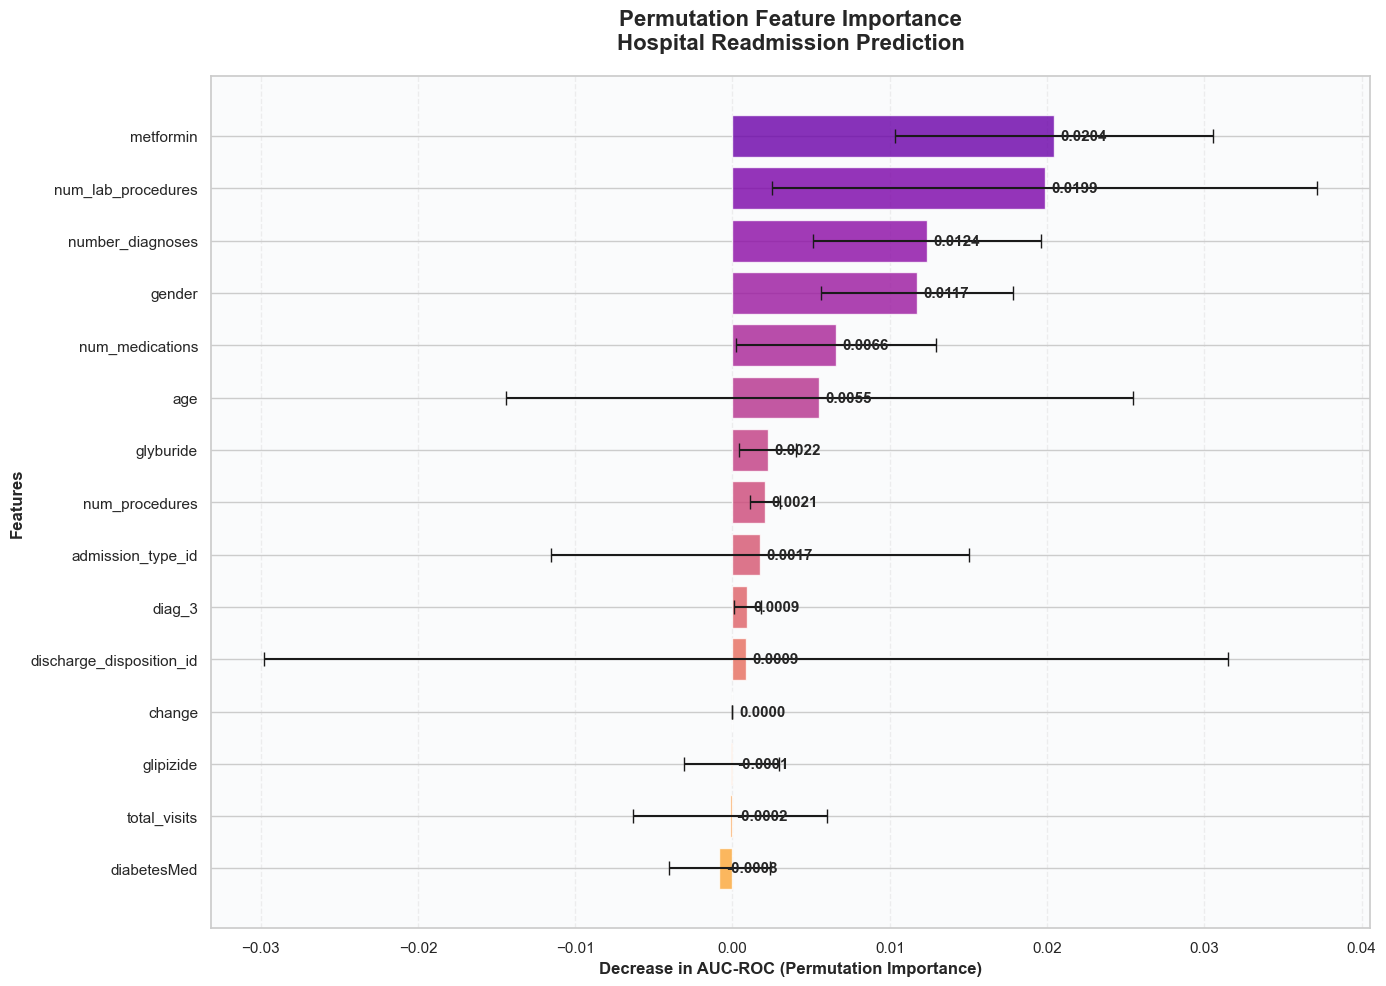

✅ Permutation importance visualization created!


In [108]:
# Create Permutation Importance Visualization

if 'perm_importance_df' in locals() and permutation_complete:
    try:
        print("📊 Creating Permutation Importance Plot...")
        
        # Get top 15 features for visualization
        top_features_df = perm_importance_df.head(15)
        
        # Create enhanced plot
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # Create horizontal bar plot with error bars
        y_pos = np.arange(len(top_features_df))
        bars = ax.barh(y_pos, top_features_df['importance_mean'], 
                      xerr=top_features_df['importance_std'],
                      alpha=0.8, capsize=5, 
                      color=plt.cm.plasma(np.linspace(0.2, 0.8, len(top_features_df))))
        
        # Styling
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_features_df['feature'])
        ax.set_xlabel('Decrease in AUC-ROC (Permutation Importance)', fontweight='bold')
        ax.set_ylabel('Features', fontweight='bold')
        ax.set_title('Permutation Feature Importance\nHospital Readmission Prediction', 
                    fontsize=16, fontweight='bold', pad=20)
        
        # Add value labels
        for i, (bar, mean_imp, std_imp) in enumerate(zip(bars, top_features_df['importance_mean'], top_features_df['importance_std'])):
            ax.text(mean_imp + max(top_features_df['importance_mean']) * 0.02, 
                   bar.get_y() + bar.get_height()/2,
                   f'{mean_imp:.4f}', va='center', ha='left', fontweight='bold')
        
        # Grid and styling
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.set_facecolor('#FAFBFC')
        ax.invert_yaxis()
        
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, "permutation_importance.png"), 
                   dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
        print("✅ Permutation importance visualization created!")
        
    except Exception as e:
        print(f"❌ Error creating visualization: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ Permutation importance data not available")

In [109]:
# Save Permutation Importance Results

if 'perm_importance_df' in locals() and permutation_complete:
    try:
        print("💾 Saving Permutation Importance results...")
        
        # Save to CSV
        perm_path = os.path.join(exports_dir, "permutation_importance.csv")
        perm_importance_df.to_csv(perm_path, index=False)
        print(f"Saved: {perm_path}")
        
        # Create comparison with SHAP if available
        if 'shap_importance_df' in locals():
            comparison_df = pd.merge(
                shap_importance_df[['feature', 'importance']].rename(columns={'importance': 'shap_importance'}),
                perm_importance_df[['feature', 'importance_mean']].rename(columns={'importance_mean': 'perm_importance'}),
                on='feature', how='outer'
            ).fillna(0)
            
            comparison_path = os.path.join(exports_dir, "shap_vs_permutation_comparison.csv")
            comparison_df.to_csv(comparison_path, index=False)
            print(f"Saved comparison: {comparison_path}")
        
        # Create summary report
        summary_path = os.path.join(exports_dir, "permutation_importance_report.txt")
        with open(summary_path, 'w') as f:
            f.write("Permutation Feature Importance Report\n")
            f.write("=" * 40 + "\n\n")
            f.write(f"Analysis Date: {pd.Timestamp.now()}\n")
            f.write(f"Number of permutations: 5\n")
            f.write(f"Scoring metric: AUC-ROC\n")
            f.write(f"Features analyzed: {len(perm_importance_df)}\n\n")
            
            f.write("TOP 10 FEATURES:\n")
            f.write("-" * 20 + "\n")
            for i, (_, row) in enumerate(perm_importance_df.head(10).iterrows(), 1):
                f.write(f"{i:2d}. {row['feature']:<25} {row['importance_mean']:.6f} (±{row['importance_std']:.6f})\n")
        
        print(f"Saved report: {summary_path}")
        print("✅ All permutation importance results saved!")
        
        # Display final summary
        print(f"\n🎯 PERMUTATION ANALYSIS COMPLETE!")
        print(f"📈 Top 5 Most Important Features:")
        for i, (_, row) in enumerate(perm_importance_df.head(5).iterrows(), 1):
            print(f"   {i}. {row['feature']:<25} {row['importance_mean']:.4f} (±{row['importance_std']:.4f})")
        
    except Exception as e:
        print(f"❌ Error saving results: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ No permutation results to save")
    print("📋 Run cells #VSC-8126caf9 and #VSC-fbd7137c first to compute permutation importance")

💾 Saving Permutation Importance results...
Saved: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports\permutation_importance.csv
Saved comparison: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports\shap_vs_permutation_comparison.csv
Saved report: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports\permutation_importance_report.txt
✅ All permutation importance results saved!

🎯 PERMUTATION ANALYSIS COMPLETE!
📈 Top 5 Most Important Features:
   1. metformin                 0.0204 (±0.0101)
   2. num_lab_procedures        0.0199 (±0.0173)
   3. number_diagnoses          0.0124 (±0.0072)
   4. gender                    0.0117 (±0.0061)
   5. num_medications           0.0066 (±0.0064)


In [110]:
# Create Power BI-ready datasets

if 'shap_importance_df' in locals() or 'perm_importance_df' in locals():
    try:
        print("📊 Creating Power BI-ready datasets...")
        
        # 1. Combined Feature Importance Dataset
        powerbi_features = pd.DataFrame()
        
        if 'shap_importance_df' in locals():
            powerbi_features = shap_importance_df[['feature', 'importance', 'rank']].copy()
            powerbi_features.rename(columns={'importance': 'shap_importance', 'rank': 'shap_rank'}, inplace=True)
        
        if 'perm_importance_df' in locals():
            if powerbi_features.empty:
                powerbi_features = perm_importance_df[['feature', 'importance_mean', 'rank']].copy()
                powerbi_features.rename(columns={'importance_mean': 'perm_importance', 'rank': 'perm_rank'}, inplace=True)
            else:
                perm_data = perm_importance_df[['feature', 'importance_mean', 'importance_std', 'rank']].copy()
                perm_data.rename(columns={'importance_mean': 'perm_importance', 'rank': 'perm_rank'}, inplace=True)
                powerbi_features = pd.merge(powerbi_features, perm_data, on='feature', how='outer')
        
        # Add feature categories for Power BI filtering
        feature_categories = {
            'Patient Demographics': ['gender', 'age'],
            'Hospital Stay': ['time_in_hospital', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'],
            'Medical Procedures': ['num_lab_procedures', 'num_procedures', 'number_diagnoses'],
            'Diagnoses': ['diag_1', 'diag_2', 'diag_3'],
            'Laboratory Tests': ['max_glu_serum', 'A1Cresult'],
            'Medications': ['num_medications', 'metformin', 'glipizide', 'glyburide', 'insulin', 'diabetesMed', 'change'],
            'Healthcare Utilization': ['total_visits']
        }
        
        def get_category(feature):
            for category, features in feature_categories.items():
                if feature in features:
                    return category
            return 'Other'
        
        powerbi_features['category'] = powerbi_features['feature'].apply(get_category)
        powerbi_features['analysis_date'] = pd.Timestamp.now().strftime('%Y-%m-%d')
        powerbi_features['model_run'] = model_dir.split('\\')[-1] if '\\' in model_dir else model_dir.split('/')[-1]
        
        # Fill missing values
        powerbi_features = powerbi_features.fillna(0)
        
        # Save main Power BI dataset
        powerbi_path = os.path.join(exports_dir, "powerbi_feature_importance.csv")
        powerbi_features.to_csv(powerbi_path, index=False)
        print(f"✅ Power BI main dataset: {powerbi_path}")
        
        # 2. Model Performance Dataset
        if 'scores_df' in locals():
            powerbi_performance = scores_df.copy()
            powerbi_performance['analysis_date'] = pd.Timestamp.now().strftime('%Y-%m-%d')
            powerbi_performance['model_run'] = model_dir.split('\\')[-1] if '\\' in model_dir else model_dir.split('/')[-1]
            
            # Add overfitting metrics
            powerbi_performance['accuracy_gap'] = powerbi_performance['Train_Accuracy'] - powerbi_performance['Test_Accuracy']
            powerbi_performance['f1_gap'] = powerbi_performance['Train_f1'] - powerbi_performance['Test_f1']
            powerbi_performance['auc_gap'] = powerbi_performance['Train_auc_roc'] - powerbi_performance['Test_auc_roc']
            
            performance_path = os.path.join(exports_dir, "powerbi_model_performance.csv")
            powerbi_performance.to_csv(performance_path, index=False)
            print(f"✅ Power BI performance dataset: {performance_path}")
        
        # 3. Feature Rankings Summary (Top 10 for dashboard)
        top_features_summary = powerbi_features.head(10).copy()
        if 'shap_importance' in top_features_summary.columns:
            top_features_summary['primary_importance'] = top_features_summary['shap_importance']
            top_features_summary['importance_type'] = 'SHAP'
        elif 'perm_importance' in top_features_summary.columns:
            top_features_summary['primary_importance'] = top_features_summary['perm_importance']
            top_features_summary['importance_type'] = 'Permutation'
        
        summary_path = os.path.join(exports_dir, "powerbi_top_features.csv")
        top_features_summary.to_csv(summary_path, index=False)
        print(f"✅ Power BI top features: {summary_path}")
        
        # 4. Category Summary for Power BI
        category_summary = powerbi_features.groupby('category').agg({
            'shap_importance': ['count', 'mean', 'sum'] if 'shap_importance' in powerbi_features.columns else ['count'],
            'perm_importance': ['count', 'mean', 'sum'] if 'perm_importance' in powerbi_features.columns else ['count']
        }).round(4)
        
        category_summary.columns = ['_'.join(col).strip() for col in category_summary.columns.values]
        category_summary = category_summary.reset_index()
        category_summary['analysis_date'] = pd.Timestamp.now().strftime('%Y-%m-%d')
        
        category_path = os.path.join(exports_dir, "powerbi_category_summary.csv")
        category_summary.to_csv(category_path, index=False)
        print(f"✅ Power BI category summary: {category_path}")
        
        # 5. Data Dictionary for Power BI
        data_dict = pd.DataFrame([
            {'table': 'powerbi_feature_importance', 'column': 'feature', 'description': 'Clinical feature name', 'type': 'Text'},
            {'table': 'powerbi_feature_importance', 'column': 'shap_importance', 'description': 'SHAP importance score (mean absolute)', 'type': 'Decimal'},
            {'table': 'powerbi_feature_importance', 'column': 'perm_importance', 'description': 'Permutation importance score (AUC decrease)', 'type': 'Decimal'},
            {'table': 'powerbi_feature_importance', 'column': 'category', 'description': 'Clinical feature category', 'type': 'Text'},
            {'table': 'powerbi_feature_importance', 'column': 'shap_rank', 'description': 'SHAP importance ranking', 'type': 'Integer'},
            {'table': 'powerbi_feature_importance', 'column': 'perm_rank', 'description': 'Permutation importance ranking', 'type': 'Integer'},
            {'table': 'powerbi_model_performance', 'column': 'Model_Name', 'description': 'Machine learning model name', 'type': 'Text'},
            {'table': 'powerbi_model_performance', 'column': 'Test_Accuracy', 'description': 'Test set accuracy score', 'type': 'Decimal'},
            {'table': 'powerbi_model_performance', 'column': 'Test_auc_roc', 'description': 'Test set AUC-ROC score', 'type': 'Decimal'},
            {'table': 'powerbi_model_performance', 'column': 'accuracy_gap', 'description': 'Training - Test accuracy (overfitting)', 'type': 'Decimal'},
        ])
        
        dict_path = os.path.join(exports_dir, "powerbi_data_dictionary.csv")
        data_dict.to_csv(dict_path, index=False)
        print(f"✅ Power BI data dictionary: {dict_path}")
        
        print(f"\n📊 POWER BI DATASETS CREATED!")
        print(f"📁 Location: {exports_dir}")
        print(f"\n🎯 Key Files for Power BI:")
        print(f"   1. powerbi_feature_importance.csv - Main analysis dataset")
        print(f"   2. powerbi_model_performance.csv - Model comparison")
        print(f"   3. powerbi_top_features.csv - Dashboard summary")
        print(f"   4. powerbi_category_summary.csv - Category analysis")
        print(f"   5. powerbi_data_dictionary.csv - Column descriptions")
        
        # Show sample data
        print(f"\n📋 Sample Data Preview:")
        print(f"\nTop 5 Features:")
        print(powerbi_features[['feature', 'category'] + 
               ([col for col in ['shap_importance', 'perm_importance'] if col in powerbi_features.columns])].head())
        
    except Exception as e:
        print(f"❌ Error creating Power BI datasets: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ No analysis results available for Power BI export")

📊 Creating Power BI-ready datasets...
✅ Power BI main dataset: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports\powerbi_feature_importance.csv
✅ Power BI performance dataset: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports\powerbi_model_performance.csv
✅ Power BI top features: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports\powerbi_top_features.csv
✅ Power BI category summary: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports\powerbi_category_summary.csv
✅ Power BI data dictionary: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports\powerbi_data_dictionary.csv

📊 POWER BI DATASETS CREATED!
📁 Location: C:\Projects\hospital_readmission_prediction\model\run_20251113_173739\exports

🎯 Key Files for Power BI:
   1. powerbi_feature_importance.csv - Main analysis dataset
   2. powerbi_model_performance.csv - Model comparison
   3. powerbi_top_features.

## End